In [1]:
import orjson
import matplotlib.pyplot as plt
from snsphd import viz
from snsphd.help import prinfo
import numpy as np
from IPython.display import JSON
from enum import Enum
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
from qutip import *

from util import (
    TomoCounts,
    Bin,
    Phase,
    create_matrix_row,
    print_matrix,
    shiftedColorMap,
)


Colors, swatches = viz.phd_style(jupyterStyle=True, grid=True)

from typing import List
from pydantic import BaseModel, validator, Field

from snsphd.obj import DataObj

In [2]:
from custom_model_dm import (
    PowerRamp,
    ValueIntegrateExtraData,
    ExtremumResults,
    pretty_print_model,
)

In [3]:
with open("../data/longer_scan_2/s_min_power_ramp.json", "rb") as f:
    data_min = orjson.loads(f.read())

with open("../data/longer_scan_2/s_d90_power_ramp.json", "rb") as f:
    data_90 = orjson.loads(f.read())

with open("../data/longer_scan_2/s_max_derived_power_ramp.json", "rb") as f:
    data_max_derived = orjson.loads(f.read())

In [4]:
ramp_min = PowerRamp(**data_min)
ramp_max = PowerRamp(**data_max_derived)
ramp_90 = PowerRamp(**data_90)

In [5]:
pretty_print_model(ramp_max, max_depth=4)

  -- 
 name: PowerRamp
   state :finished
   label :default_label
   results <list>
     0 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     1 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     2 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     3 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: Sim

In [6]:
from typing import Union, get_origin, get_args


def print_string_or_none(value: Union[str, None]):
    if get_origin(Union) == type(value) and str in get_args(Union):
        print(value)
    else:
        print("NaN")

In [7]:
from typing import Union, get_origin, get_args
from dataclasses import dataclass


@dataclass
class MyClass:
    name: str
    value: Union[str, None]

    def print_value(self):
        if get_origin(Union) == type(self.value) and str in get_args(Union):
            print(f"{self.name}: {self.value}")
        else:
            print(f"{self.name}: NaN")

In [9]:
pretty_print_model(ramp_min.results[3].results[2])

  -- 
 name: Extremum
   results -- 
     counts_list <list>
       0 :801
       1 :801
       2 :801
       3 :801
       4 :802
       5 :801
       6 :801
     times_list <list>
       0 :280.9057409763336
       1 :295.93887877464294
       2 :311.95584416389465
       3 :265.20647740364075
       4 :292.01120233535767
       5 :293.73412132263184
       6 :305.67842078208923
     direction_array <list>
     voltage_list <list>
       0 :2.54375
       1 :2.54
       2 :2.53625
       3 :2.5324999999999998
       4 :2.53625
       5 :2.54
       6 :2.54375
   integration_results <list>
     0 -- 
     name: ValueIntegrateExtraData
       label :default_label
       counts :801
       delta_time :280.9057409763336
       coincidences_hist_1 :...data...type: <class 'numpy.float64'>
       coincidences_hist_2 :...data...type: <class 'numpy.float64'>
       full_coinc_1 :...data...type: <class 'numpy.float64'>
       full_coinc_2 :...data...type: <class 'numpy.float64'>
       singles

In [10]:
# ramp_90.results[3]


class DMData(BaseModel):
    phase_90: List[ValueIntegrateExtraData]
    phase_min_res: ExtremumResults
    phase_min: List[ValueIntegrateExtraData]
    phase_max: List[ValueIntegrateExtraData]
    # phase_max_res: ExtremumResults


power_steps: List[DMData] = []
powers = []

for i in range(len(ramp_90.results) - 1):
    scan_step_90 = ramp_90.results[i]
    scan_step_min = ramp_min.results[i]
    scan_step_max = ramp_max.results[i]

    powers.append(scan_step_90.results[0].results.expected_amps)
    #    scan_step_min.results[0].result.expected_amps,
    #    scan_step_max.results[0].result.expected_amps])

    # you WILL be changing these when you switch to singleSet for the 90 and max phase settings
    int_results_90: List[ValueIntegrateExtraData] = scan_step_90.results[2].results
    int_results_min: List[ValueIntegrateExtraData] = scan_step_min.results[
        2
    ].integration_results
    int_results_min_res: ExtremumResults = scan_step_min.results[2].results
    int_results_max_res: ExtremumResults = scan_step_max.results[2].results

    int_results_max = scan_step_max.results[2].results

    power_steps.append(
        DMData(
            phase_90=int_results_90,
            phase_min=int_results_min,
            phase_max=int_results_max,
            phase_min_res=int_results_min_res,
        )
    )

140


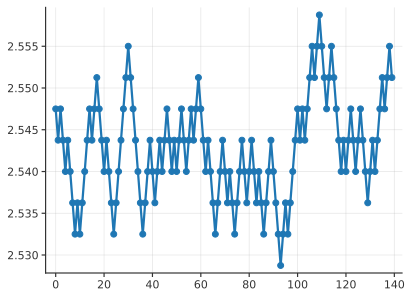

<Figure size 1600x1200 with 0 Axes>

In [11]:
voltages = []
counts = []
times = []

max_counts = []
max_times = []

singles_A = []
singles_B = []
coincidences = []

for power in power_steps:
    # print(power.phase_min_res.voltage_list)
    voltages.extend(power.phase_min_res.voltage_list)
    counts.append(power.phase_min_res.counts_list)
    times.append(power.phase_min_res.times_list)
    # max_counts.append(power.phase_max_res.counts_list)
    # max_times.append(power.phase_max_res.times_list)

    sect = power.phase_90[0]
    Sa = np.sum(sect.singles_hist_1) / sect.delta_time
    Sb = np.sum(sect.singles_hist_2) / sect.delta_time
    Cc = sect.total_coincidences / sect.delta_time

    singles_A.append(Sa)
    singles_B.append(Sb)
    coincidences.append(Cc)

plt.plot(voltages, "-o")
print(len(voltages))
plt.figure()

counts_avg = np.average(counts, axis=1)
counts_std = np.std(counts, axis=1)

times_avg = np.average(times, axis=1)
times_std = np.std(times, axis=1)

# max_counts_avg = np.average(max_counts, axis=1)
# max_times_avg = np.average(max_times, axis=1)

# MIN = counts_avg/times_avg
# MAX = max_counts_avg/max_times_avg

# plt.plot(counts_avg/times_avg, '-o')
# plt.yscale('log')

# plt.figure()
# plt.plot(1 - MIN/MAX)

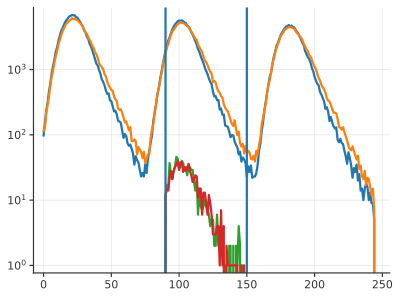

In [12]:
power_idx = 1
iter_idx = 0
hist1, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].full_coinc_1, bins=np.arange(250)
)
hist2, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].full_coinc_2, bins=np.arange(250)
)

hist1_i, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].coincidences_hist_1, bins=np.arange(250)
)
hist2_i, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].coincidences_hist_2, bins=np.arange(250)
)

plt.plot(bins[:-1], hist1)
plt.plot(bins[:-1], hist2)

plt.plot(bins[:-1], hist1_i)
plt.plot(bins[:-1], hist2_i)
plt.yscale("log")
plt.axvline(x=90)
plt.axvline(x=150)

In [59]:
# this takes a while


# idx = 5 # goes over the repeated integrations


class ArrayData(BaseModel):
    avg: np.ndarray  # ultimately gets converted to np.ndarray, but 'list' keeps mypy happy
    std: np.ndarray

    @validator("avg", "std", pre=True)
    def to_numpy_float(cls, value) -> np.ndarray:
        return np.array(value, dtype=float)

    class Config:
        arbitrary_types_allowed = True


class TomoOutput(BaseModel):
    fidelities: ArrayData
    fidelities_sub: ArrayData
    rates: ArrayData
    log_negativities: ArrayData
    coherent_infos: ArrayData
    car_mu: ArrayData
    qber: ArrayData
    visibilities: ArrayData


class ThisPowerTomoOutput(BaseModel):
    this_power_tomos: list
    this_power_coherent_infos: list
    this_power_log_negativities: list
    this_power_fidelities: list
    this_power_fidelities_sub: list
    this_power_rates: list
    this_power_car_mu: list
    this_power_qber: list
    this_power_visibilities: list


def tomo_from_power_step(
    step: DMData,
    print_output: bool = False,
    bin_ranges: list[list[int]] = [[0, 75], [85, 155], [165, 240]],
    verbose: bool = False,
) -> ThisPowerTomoOutput:
    """
    Takes a power step and returns the tomography results
    """
    this_power_coherent_infos = []
    this_power_log_negativities = []
    this_power_fidelities = []
    this_power_fidelities_sub = []
    this_power_rates = []
    this_power_tomos = []
    this_power_car_mu = []
    this_power_qber = []
    this_power_visibilities = []
    for idx in range(
        2, len(step.phase_max)
    ):  # the number of integrations in each power
        # ddic = step.phase_max[idx]

        tomo = TomoCounts()

        tags_1 = step.phase_90[idx].full_coinc_1
        tags_2 = step.phase_90[idx].full_coinc_2

        tags_in_guard_region_1 = np.bitwise_or(
            [(tags_1 > bin_ranges[0][1]) & (tags_1 < bin_ranges[1][0])],
            [(tags_1 > bin_ranges[1][1]) & (tags_1 < bin_ranges[2][0])],
        )
        tags_in_guard_region_2 = np.bitwise_or(
            [(tags_2 > bin_ranges[0][1]) & (tags_2 < bin_ranges[1][0])],
            [(tags_2 > bin_ranges[1][1]) & (tags_2 < bin_ranges[2][0])],
        )

        print("tags in 1: ", np.sum(tags_in_guard_region_1))
        print("tags in 2: ", np.sum(tags_in_guard_region_2))

        tags_in_guard_regions = np.logical_or(
            tags_in_guard_region_1, tags_in_guard_region_2
        )
        print("guard region filtered tags: ", np.sum(tags_in_guard_regions))

        total_rate = (
            len(step.phase_90[idx].full_coinc_1) - np.sum(tags_in_guard_regions)
        ) / step.phase_90[idx].delta_time

        print("total rate 1: ", total_rate)
        print(
            "total rate 2: ",
            len(step.phase_90[idx].full_coinc_1) / step.phase_90[idx].delta_time,
        )
        print(
            "total rate 3: ",
            8
            * step.phase_min[idx].total_coincidences
            / (6 * step.phase_min[idx].delta_time),
        )
        print()

        if print_output:
            print("total rate: ", total_rate)
            print("length: ", len(step.phase_90[idx].full_coinc_1))
            print("delta time: ", step.phase_90[idx].delta_time)

        singles_rate_A = (
            np.sum(step.phase_min[idx].singles_hist_1) / step.phase_min[idx].delta_time
        )
        singles_rate_B = (
            np.sum(step.phase_min[idx].singles_hist_2) / step.phase_min[idx].delta_time
        )
        if print_output:
            print("singles rate A: ", singles_rate_A)
        if print_output:
            print("singles rate B: ", singles_rate_B)

        ratio_of_singles_A_in_center_bin = np.sum(
            step.phase_min[idx].singles_hist_1[90:150]
        ) / np.sum(step.phase_min[idx].singles_hist_1)
        ratio_of_singles_B_in_center_bin = np.sum(
            step.phase_min[idx].singles_hist_2[90:150]
        ) / np.sum(step.phase_min[idx].singles_hist_2)
        if print_output:
            print(
                "ratio of singles A in center bin: ", ratio_of_singles_A_in_center_bin
            )
        if print_output:
            print(
                "ratio of singles B in center bin: ", ratio_of_singles_B_in_center_bin
            )

        singles_center_drc_A_rate = (
            ratio_of_singles_A_in_center_bin * singles_rate_A * 1
        )  # * (1 - 0.393) # 0.393 is the geometric factor
        singles_center_drc_B_rate = (
            ratio_of_singles_B_in_center_bin * singles_rate_B * 1
        )  # * (1 - 0.393) # 0.393 is the geometric factor
        # print("singles center drc A rate: ", singles_center_drc_A_rate)
        # print("singles center drc B rate: ", singles_center_drc_B_rate)

        ratio_of_laser_pulses_with_dcr_A = singles_center_drc_A_rate / 4e9
        ratio_of_laser_pulses_with_dcr_B = singles_center_drc_B_rate / 4e9

        ratio_of_laser_pulses_with_drc_coincidence = (
            ratio_of_laser_pulses_with_dcr_A * ratio_of_laser_pulses_with_dcr_B
        )

        rate_of_drc_coincidences = ratio_of_laser_pulses_with_drc_coincidence * 4e9
        # print("     rate of drc coincidences: ", rate_of_drc_coincidences)

        # print("singles rate A: ", singles_rate_A)
        # print("singles rate B: ", singles_rate_B)

        tomo.fill(
            Phase.DD,
            step.phase_max[idx].full_coinc_1,
            step.phase_max[idx].full_coinc_2,
            step.phase_max[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.DR,
            step.phase_90[idx].full_coinc_1,
            step.phase_90[idx].full_coinc_2,
            step.phase_90[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.RD,
            step.phase_90[idx].full_coinc_1,
            step.phase_90[idx].full_coinc_2,
            step.phase_90[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.RR,
            step.phase_min[idx].full_coinc_1,
            step.phase_min[idx].full_coinc_2,
            step.phase_min[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.calculate_density_matrix()

        # fidelity = (step.phase_min[idx].counts / step.phase_min[idx].delta_time) / (
        #     step.phase_max[idx].counts / step.phase_max[idx].delta_time
        # )
        tomo.rate_drc_coinc = rate_of_drc_coincidences

        fidelity_sub = tomo.calculate_fidelity(dcr_subtraction=True)
        fidelity = tomo.calculate_fidelity(dcr_subtraction=False)

        if print_output:
            print("rate in minimized center bin: ", tomo.rr[-1])

        log_negativity = tomo.calculate_log_negativity(tomo.rho)
        coherent_info = tomo.calculate_coherent_information(tomo.rho)

        this_power_log_negativities.append(log_negativity)
        this_power_coherent_infos.append(coherent_info)

        this_power_qber.append(tomo.calculate_qber())
        this_power_visibilities.append(tomo.calculate_visibility())

        this_power_fidelities.append(fidelity)
        this_power_fidelities_sub.append(fidelity_sub)
        this_power_rates.append(total_rate)
        this_power_tomos.append(tomo)
        this_power_car_mu.append(tomo.calculate_car_mu())
        if print_output:
            print("car mu: ", tomo.calculate_car_mu())

    return ThisPowerTomoOutput(
        this_power_tomos=this_power_tomos,
        this_power_coherent_infos=this_power_coherent_infos,
        this_power_log_negativities=this_power_log_negativities,
        this_power_fidelities=this_power_fidelities,
        this_power_fidelities_sub=this_power_fidelities_sub,
        this_power_rates=this_power_rates,
        this_power_car_mu=this_power_car_mu,
        this_power_qber=this_power_qber,
        this_power_visibilities=this_power_visibilities,
    )


def do_tomography_and_export_metrics(
    power_steps: List[DMData], print_output=False
) -> tuple[TomoOutput, list[list[TomoCounts]]]:
    coherent_infos_avg = []
    coherent_infos_std = []

    log_negativities_avg = []
    log_negativities_std = []

    fidelities_avg = []
    fidelities_std = []

    fidelities_sub_avg = []
    fidelities_sub_std = []

    car_mu_avg = []
    car_mu_std = []

    rates_avg = []
    rates_std = []
    tomos = []

    qber_avg = []
    qber_std = []

    visibilities_avg = []
    visibilities_std = []

    for i in range(len(power_steps)):
        step: DMData = power_steps[i]
        t = tomo_from_power_step(step, print_output)

        # print(t)
        coherent_infos_avg.append(np.average(t.this_power_coherent_infos))
        coherent_infos_std.append(np.std(t.this_power_coherent_infos))
        log_negativities_avg.append(np.average(t.this_power_log_negativities))
        log_negativities_std.append(np.std(t.this_power_log_negativities))

        fidelities_avg.append(np.average(t.this_power_fidelities))
        fidelities_std.append(np.std(t.this_power_fidelities))

        fidelities_sub_avg.append(np.average(t.this_power_fidelities_sub))
        fidelities_sub_std.append(np.std(t.this_power_fidelities_sub))

        qber_avg.append(np.average(t.this_power_qber))
        qber_std.append(np.std(t.this_power_qber))

        # prinfo(fidelities_avg)
        # prinfo(fidelities_std)
        rates_avg.append(np.average(t.this_power_rates))
        rates_std.append(np.std(t.this_power_rates))
        car_mu_avg.append(np.average(t.this_power_car_mu))
        car_mu_std.append(np.std(t.this_power_car_mu))
        tomos.append(t.this_power_tomos)

        visibilities_avg.append(np.average(t.this_power_visibilities))
        visibilities_std.append(np.std(t.this_power_visibilities))

    output = TomoOutput(
        fidelities=ArrayData(avg=fidelities_avg, std=fidelities_std),
        fidelities_sub=ArrayData(avg=fidelities_sub_avg, std=fidelities_sub_std),
        rates=ArrayData(avg=rates_avg, std=rates_std),
        log_negativities=ArrayData(avg=log_negativities_avg, std=log_negativities_std),
        coherent_infos=ArrayData(avg=coherent_infos_avg, std=coherent_infos_std),
        car_mu=ArrayData(
            avg=car_mu_avg,
            std=car_mu_std,
        ),
        qber=ArrayData(
            avg=qber_avg,
            std=qber_std,
        ),
        visibilities=ArrayData(
            avg=visibilities_avg,
            std=visibilities_std,
        ),
    )

    return output, tomos

In [60]:
tomography_result, tomos = do_tomography_and_export_metrics(
    power_steps, print_output=False
)

tags in 1:  670
tags in 2:  577
guard region filtered tags:  1244
total rate 1:  390.43852654565745
total rate 2:  395.8917867545204
total rate 3:  424.5289548513655

tags in 1:  646
tags in 2:  558
guard region filtered tags:  1198
total rate 1:  392.3318954438488
total rate 2:  397.58016033667263
total rate 3:  423.876440013508

tags in 1:  633
tags in 2:  536
guard region filtered tags:  1162
total rate 1:  400.8338207972424
total rate 2:  406.1147071992016
total rate 3:  415.8085173347854

tags in 1:  658
tags in 2:  523
guard region filtered tags:  1174
total rate 1:  403.49681978818506
total rate 2:  408.83434391698876
total rate 3:  409.59322072549566

tags in 1:  726
tags in 2:  592
guard region filtered tags:  1314
total rate 1:  403.1492335439957
total rate 2:  409.0175422242674
total rate 3:  408.40868669347543

tags in 1:  585
tags in 2:  499
guard region filtered tags:  1074
total rate 1:  699.6952669802448
total rate 2:  708.266775423593
total rate 3:  717.6576290908838



In [61]:
tomography_result.visibilities

ArrayData(avg=array([0.99218119, 0.99208958, 0.99214858, 0.99220904, 0.9918106 ,
       0.99119095, 0.99191277, 0.9906501 , 0.99063097, 0.98938722,
       0.98883828, 0.98843512, 0.98821369, 0.98668978, 0.98655281,
       0.98532416, 0.98378176, 0.98467731, 0.98167598, 0.9795318 ]), std=array([4.86371826e-04, 2.46992990e-04, 2.20973840e-04, 3.57805432e-04,
       4.63646144e-04, 1.09203541e-04, 7.76064138e-05, 1.65161020e-04,
       3.12501635e-04, 3.95621646e-04, 6.16830069e-04, 5.26879563e-04,
       5.73141245e-04, 4.11420342e-04, 5.49783330e-04, 7.88798640e-04,
       7.07997047e-04, 5.54464256e-04, 4.73915692e-04, 1.01855131e-03]))

In [70]:
# investivate how fidelities change with guard region size

fidelities_guard_scan_avg = []
fidelities_guard_scan_std = []
guard_sizes = []
coherent_infos_guard_scan_avg = []
coherent_infos_guard_scan_std = []
rates_guard_scan_avg = []
for x in range(0, 40, 2):
    guard_sizes.append(2*x)
    bin_range = [[0, 80-x], [80+x, 160-x], [160+x, 240]]
    print(bin_range)
    t = tomo_from_power_step(power_steps[0], print_output=False, bin_ranges = bin_range)
    fidelities_guard_scan_avg.append(np.average(t.this_power_fidelities))
    fidelities_guard_scan_std.append(np.std(t.this_power_fidelities))
    coherent_infos_guard_scan_avg.append(np.average(t.this_power_coherent_infos))
    coherent_infos_guard_scan_std.append(np.std(t.this_power_coherent_infos))
    rates_guard_scan_avg.append(np.average(t.this_power_rates))
    # print(t.this_power_fidelities)

[[0, 80], [80, 160], [160, 240]]
tags in 1:  0
tags in 2:  0
guard region filtered tags:  0
total rate 1:  395.8917867545204
total rate 2:  395.8917867545204
total rate 3:  424.5289548513655

tags in 1:  0
tags in 2:  0
guard region filtered tags:  0
total rate 1:  397.58016033667263
total rate 2:  397.58016033667263
total rate 3:  423.876440013508

tags in 1:  0
tags in 2:  0
guard region filtered tags:  0
total rate 1:  406.1147071992016
total rate 2:  406.1147071992016
total rate 3:  415.8085173347854

tags in 1:  0
tags in 2:  0
guard region filtered tags:  0
total rate 1:  408.83434391698876
total rate 2:  408.83434391698876
total rate 3:  409.59322072549566

tags in 1:  0
tags in 2:  0
guard region filtered tags:  0
total rate 1:  409.0175422242674
total rate 2:  409.0175422242674
total rate 3:  408.40868669347543

[[0, 78], [82, 158], [162, 240]]
tags in 1:  185
tags in 2:  152
guard region filtered tags:  337
total rate 1:  394.4144968104796
total rate 2:  395.8917867545204
tot

c:\Users\Andrew\mambaforge\envs\research11\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 3400.
  warnings.warn(errors[info][0], RuntimeWarning)


tags in 1:  3077
tags in 2:  2479
guard region filtered tags:  5445
total rate 1:  373.72640212179306
total rate 2:  397.58016033667263
total rate 3:  423.876440013508

tags in 1:  3136
tags in 2:  2368
guard region filtered tags:  5398
total rate 1:  381.58267208923985
total rate 2:  406.1147071992016
total rate 3:  415.8085173347854

tags in 1:  3243
tags in 2:  2403
guard region filtered tags:  5537
total rate 1:  383.66068880524585
total rate 2:  408.83434391698876
total rate 3:  409.59322072549566

tags in 1:  3402
tags in 2:  2678
guard region filtered tags:  5957
total rate 1:  382.41364967603397
total rate 2:  409.0175422242674
total rate 3:  408.40868669347543

[[0, 68], [92, 148], [172, 240]]
tags in 1:  5478
tags in 2:  4381
guard region filtered tags:  9528
total rate 1:  354.1243725503031
total rate 2:  395.8917867545204
total rate 3:  424.5289548513655

tags in 1:  5179
tags in 2:  4128
guard region filtered tags:  9017
total rate 1:  358.07798626439177
total rate 2:  397

dict_keys(['coinc_min', 'coinc_max', 'singles_A', 'singles_B'])
['..', 'figs', 'guard_scan']
../figs/
pickleable


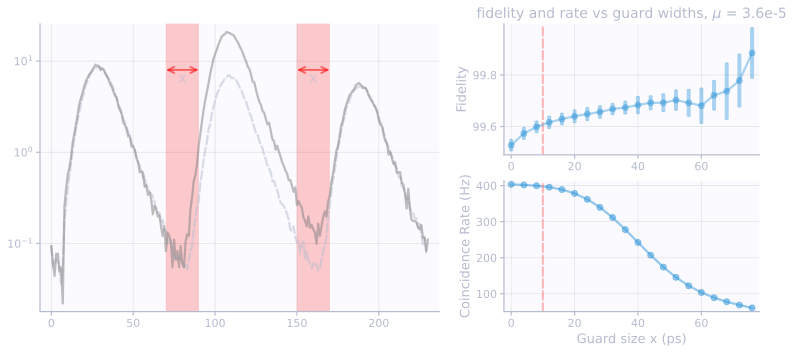

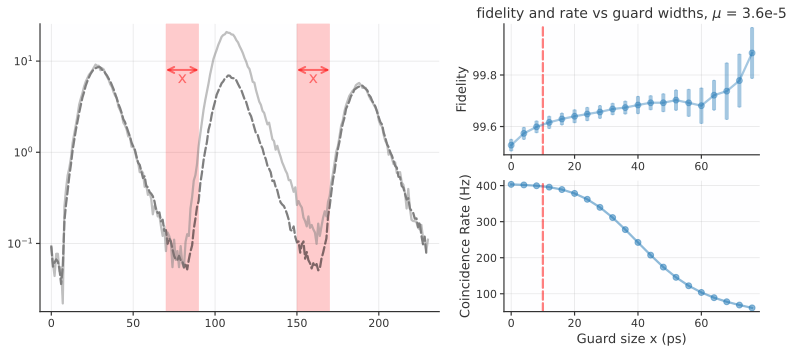

In [122]:
from snsphd.layout import bisect
from snsphd.obj import DataObj
from snsphd.viz import plot_arrows

d = DataObj.from_file("histogram_data.json")

fig = plt.figure(figsize = (10,4))

left, right = bisect([0,0,1,1],direction="vert", offset=0.6, spacing=0.09, absolute_spacing=True)
bottom_right, top_right = bisect(right, direction="horiz", offset=0.5, spacing=0.09, absolute_spacing=True)

hist = fig.add_axes(left)

fids = fig.add_axes(top_right)
rates = fig.add_axes(bottom_right, sharex=fids)

hist.plot(np.arange(0,len(d.coinc_min)-8), np.roll(d.coinc_min[:-8],8), '--', alpha=0.5, color="black", )
hist.plot(np.arange(0,len(d.coinc_max)-8), np.roll(d.coinc_max[:-8],8), '-', alpha=0.5, color="grey")
hist.set_yscale('log')
hist.axvspan(70, 90, alpha=0.2, color='red')
hist.axvspan(150, 170, alpha=0.2, color='red')
plot_arrows(hist, (70, 8), (90, 8), color='red', alpha=0.5, lw=2, label="x", fontsize=16, arrowsize=15)
plot_arrows(hist, (150, 8), (170, 8), color='red', alpha=0.5, lw=2, label="x", fontsize=16, arrowsize=15)

fids.errorbar(guard_sizes, fidelities_guard_scan_avg, yerr=fidelities_guard_scan_std, fmt='o', elinewidth=4,
        alpha=0.4,ls='-', label='Fidelity')
fids.set_ylabel("Fidelity")
rates.plot(guard_sizes, rates_guard_scan_avg, 'o', ls='-', label='Rate', alpha=0.5)
rates.set_ylabel("Coincidence Rate (Hz)")
rates.set_xlabel("Guard size x (ps)")
rates.axvline(x=10, ls='--', color='red', alpha=0.5)
fids.axvline(x=10, ls='--', color='red', alpha=0.5)
fids.set_title(r"fidelity and rate vs guard widths, $\mu$ = 3.6e-5")

viz.save_light_dark_all(fig, "../figs/guard_scan", override_alpha=True)

In [115]:
tomo = tomos[-1][-1]

print(tomo)
tomo.calculate_coherent_information(tomo.rho)
tomo.calculate_fidelity()

phase		|dd>		|dr>		|rd>		|rr>
ee: 		3472.5177	3921.4602	3921.4602	4085.4529	
el: 		29.1675		46.1314		46.1314		43.3813		
ed: 		3091.2196	0.0		3320.0216	0.0		
er: 		0.0		3320.0216	0.0		3506.2789	
le: 		16.9702		24.219		24.219		25.3614		
ll: 		2140.3607	2394.7981	2394.7981	2464.9936	
ld: 		2552.9475	0.0		2759.2364	0.0		
lr: 		0.0		2759.2364	0.0		2856.8938	
de: 		2848.3343	3125.693	0.0		0.0		
dl: 		2726.3613	2913.7767	0.0		0.0		
dd: 		10984.4624	0.0		0.0		0.0		
dr: 		0.0		5918.663	0.0		0.0		
re: 		0.0		0.0		3125.693	3303.7882	
rl: 		0.0		0.0		2913.7767	3048.1721	
rd: 		0.0		0.0		5918.663	0.0		
rr: 		0.0		0.0		0.0		117.9972	



98.9257808374855

In [116]:
geometric_factor = (
    0.393  # a result of the JSI modelling analysis: gamma_geo = 0.393 +/- 0.012
)

mus = (
    np.array(singles_A)
    * np.array(singles_B)
    * geometric_factor
    / (np.array(coincidences) * 4e9)
)


# mu_std = np.sqrt(p1**2 + p2**2 + p3**2)
p1 = ((np.array(singles_A)* geometric_factor)/(np.array(coincidences) * 4e9))*np.sqrt(singles_B)
p2 = ((np.array(singles_B)* geometric_factor)/(np.array(coincidences) * 4e9))*np.sqrt(singles_A)
p3 = ((np.array(singles_B) * np.array(singles_A)* geometric_factor)/((np.array(coincidences)**2) * 4e9))*np.sqrt(coincidences)
mu_std = np.sqrt(p1**2 + p2**2 + p3**2)
prinfo(mu_std)
prinfo(mus)

mu_std = [1.94624625e-06 2.61942431e-06 3.35118313e-06 3.93668519e-06
 4.69459186e-06 5.33829095e-06 6.09919848e-06 6.91377972e-06
 7.64273810e-06 8.58402144e-06 9.69122662e-06 1.06624178e-05
 1.14633460e-05 1.23078233e-05 1.33026532e-05 1.40056644e-05
 1.46692694e-05 1.57184151e-05 1.62013865e-05 1.79837190e-05]
mus = [3.68473904e-05 6.76276675e-05 1.10686376e-04 1.52007563e-04
 2.17046996e-04 2.77240344e-04 3.63844586e-04 4.50627139e-04
 5.61979778e-04 6.92438519e-04 8.49202930e-04 1.02503975e-03
 1.18439516e-03 1.36144292e-03 1.57596573e-03 1.72689863e-03
 1.93687043e-03 2.13747196e-03 2.31636993e-03 2.71209834e-03]


Text(0.5, 1.0, 'visiblity vs mu')

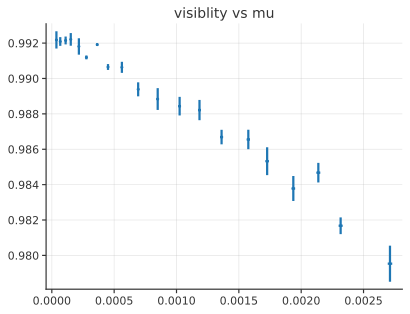

In [117]:
plt.errorbar(mus, tomography_result.visibilities.avg, xerr = mu_std, yerr=tomography_result.visibilities.std, fmt='o', markersize=2, capsize=0)
plt.title("visiblity vs mu")

In [120]:
mus[0]

3.684739044879509e-05

In [ ]:
### powers (SHG amps) vs coincidence rates

class Parabola:
    def __init__(self, coeffs):
        self.coeffs = coeffs
    def __call__(self, x):
        return self.coeffs[0]*x**2 + self.coeffs[1]*x + self.coeffs[2]
    
    def inverse(self, y):
        a, b, c = self.coeffs
        x1 = (-b + np.sqrt(b**2 - 4*a*(c-y))) / (2*a)
        x2 = (-b - np.sqrt(b**2 - 4*a*(c-y))) / (2*a)
        return x1, x2

para = Parabola(np.polyfit(powers, mus, 2))

mus_temp = np.linspace(0, 0.005, 200)
# print(mus_temp)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(powers, mus)
ax.plot(powers, para(powers))
ax.set_title("mu vs SHG power")


fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(mus, powers)
ax.plot(mus_temp, para.inverse(mus_temp)[0])

used_mus = np.linspace(0.005/20,0.0051, 20) - .0002
used_powers = para.inverse(used_mus)[0]


for p, mu in zip(used_powers, used_mus):
    print(f"mu: {mu:.4f}, power: {p:.4f}")

# print(used_powers)
for mu in used_mus:
    ax.axvline(mu, color="k", alpha=0.2)

In [194]:
@dataclass
class Line:
    slope: float
    intercept: float

    def __call__(self, x):
        return self.slope * x + self.intercept

Line(slope=2.8808297571539874, intercept=0.0030833806068345884)


Text(0, 0.5, 'mu defined from CAR')

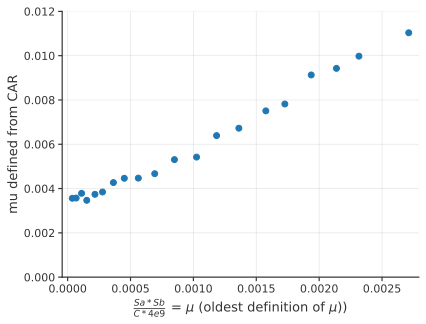

In [141]:
plt.plot(mus, tomography_result.car_mu.avg, "o")

coeffs = np.polyfit(mus, tomography_result.car_mu.avg, 1)
car_mu_line = Line(coeffs[0], coeffs[1])
print(car_mu_line)

car_mus = mus*car_mu_line.slope + car_mu_line.intercept
# plt.plot(mus, car_mus, label="car mu line")
plt.ylim(0,0.012)
plt.xlabel(r"$\frac{Sa*Sb}{C*4e9}$ = $\mu$ (oldest definition of $\mu$))")
plt.ylabel("mu defined from CAR")


In [20]:
# mus = car_mus

In [142]:
tomography_result.fidelities_sub.avg

array([99.64648803, 99.64968198, 99.65419114, 99.66056205, 99.64701971,
       99.6264693 , 99.6690683 , 99.62406797, 99.63753826, 99.59385126,
       99.58548768, 99.58888   , 99.59517543, 99.54547548, 99.55882437,
       99.519591  , 99.50559436, 99.5545385 , 99.49154606, 99.41007208])

In [143]:
tomography_result.fidelities.std

array([0.02533028, 0.0122215 , 0.01591554, 0.02189507, 0.02330211,
       0.00900767, 0.00606336, 0.01292106, 0.01701776, 0.02002908,
       0.0270281 , 0.02760785, 0.02890005, 0.02380884, 0.02291791,
       0.03627548, 0.04202096, 0.03028539, 0.0273297 , 0.04993742])

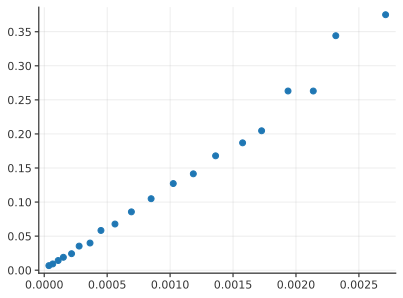

In [144]:
plt.plot(mus, tomography_result.fidelities_sub.avg - tomography_result.fidelities.avg, "o")
# viz.save_light_dark_all(name="test")

In [208]:
power_labels

[1.2, 2.32, 2.83, 3.25, 3.65, 3.97]

secret key rate error due to qber [  3.29410733   2.83127963   5.96126873  11.15013364  16.87582368
   8.14773043   7.24568872  18.5067952   30.23265558  42.49009333
  66.28828907  81.02407891  97.02398056  89.34678445  98.60239404
 165.97557115 213.05795436 169.2371869  158.00670495 320.96270865]
secret key rate error due to rate [ -10.49301797   -9.37534962  -11.07533588   -7.61013655  -14.61388497
  -22.51487033  -46.08342659  -56.65528921  -51.02341934  -54.15623448
  -20.63313291  -27.60379627  -91.78828184  -48.34093922 -117.92512806
  -61.02485905 -116.77777978 -163.5400109  -220.33688706 -245.24230899]
[1.2, 2.32, 2.83, 3.25, 3.65, 3.97]
['..', 'figs', 'shg_scan']
../figs/
pickleable


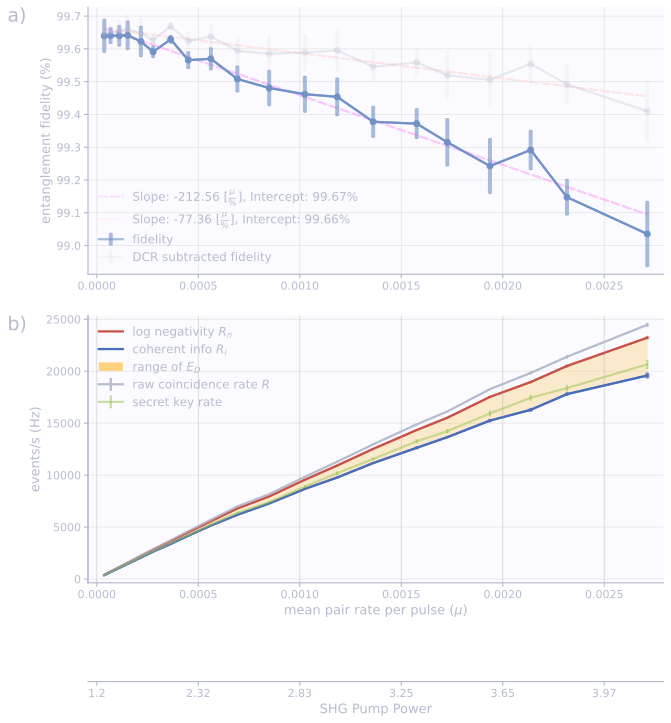

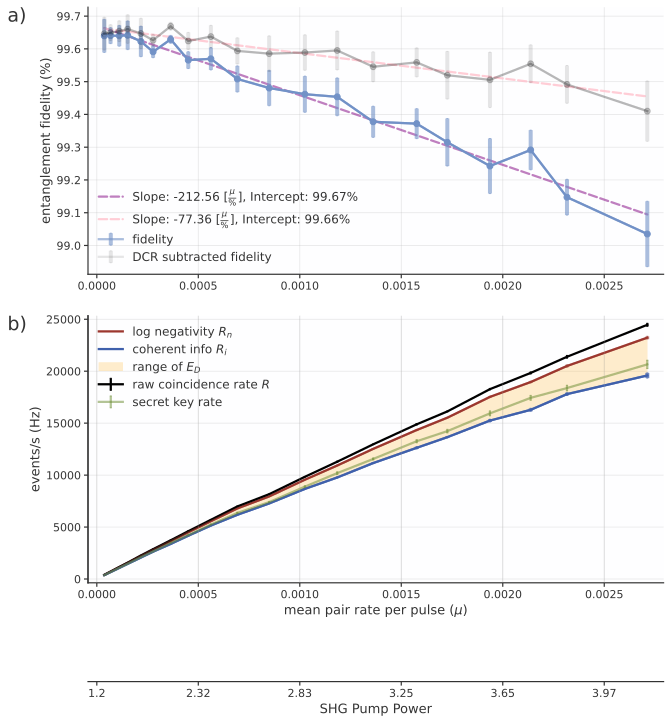

In [195]:
viz.update_colors(dark=False)

from scipy import interpolate
from snsphd.layout import bisect


fig = plt.figure(figsize=(8, 8))
divider_width = 0.09
master_bottom, master_top = bisect(
    [0, 0, 1, 1],
    direction="horiz",
    offset=0.5,
    spacing=divider_width * 0.8,
    absolute_spacing=True,
)


# top_left, top_right = bisect(
#     master_top,
#     direction="vert",
#     offset=0.65,
#     spacing=divider_width,
#     absolute_spacing=True,
# )
# bottom_left, bottom_right = bisect(
#     master_bottom,
#     direction="vert",
#     offset=0.65,
#     spacing=divider_width,
#     absolute_spacing=True,
# )

fidelities = fig.add_axes(master_top)
rates = fig.add_axes(master_bottom)
# extrapolate_fidelities = fig.add_axes(top_right)
# extrapolate_rates = fig.add_axes(bottom_right)


powers = np.array(powers)


def comb(set1, set2):
    return np.sqrt(set1**2 + set2**2)


def plot_fidelities(ax, mus, res: TomoOutput, zoomed_out: bool = False) -> Line:
    # coeffs = np.polyfit(mus, y, 1)
    coeffs = np.polyfit(mus, res.fidelities_sub.avg, 1)
    fidelity_sub_line = Line(coeffs[0], coeffs[1])

    coeffs = np.polyfit(mus, res.fidelities.avg, 1)
    fidelity_line = Line(coeffs[0], coeffs[1])
    ax.plot(
        mus,
        fidelity_line.slope * mus + fidelity_line.intercept,
        color="purple",
        linestyle="--",
        label=rf"Slope: {fidelity_line.slope:.2f} ${{[\frac{{\mu}}{{\%}}]}}$, Intercept: {fidelity_line.intercept:.2f}%",
        alpha=0.5,
    )

    y = res.fidelities.avg
    if zoomed_out:
        ax.plot(mus, y, "-o", color=Colors["blue"], markersize=5)

    else:
        ax.set_ylabel("entanglement fidelity (%)")

        ax.plot(
            mus,
            fidelity_sub_line.slope * mus + fidelity_sub_line.intercept,
            color="pink",
            linestyle="--",
            label=rf"Slope: {fidelity_sub_line.slope:.2f} ${{[\frac{{\mu}}{{\%}}]}}$, Intercept: {fidelity_sub_line.intercept:.2f}%",
            alpha=0.8,
        )

        ax.errorbar(
            mus,
            res.fidelities.avg,
            yerr=2 * res.fidelities.std,
            elinewidth=4,
            alpha=0.6,
            color=Colors["blue"],
            label="fidelity",
        )
        ax.plot(mus, y, "-o", color=Colors["blue"])

        # DCR subtracted fidelity line
        ax.errorbar(
            mus,
            res.fidelities_sub.avg,
            yerr=2 * res.fidelities_sub.std,
            elinewidth=4,
            alpha=0.1,
            color="k",
            label="DCR subtracted fidelity",
        )
        ax.plot(mus, res.fidelities_sub.avg, "-o", color="k", alpha=0.2)

    return fidelity_line, fidelity_sub_line


def secret_key_mult(q):
    return (1 - 2 * (-q * np.log2(q) - (1 - q) * np.log2(1 - q)))


def secret_key_rate(raw_rate, q):
    # = 1 - 2H(q) where H(q) is the binary entropy function
    return raw_rate*secret_key_mult(q)



def plot_rates(ax, mus, res: TomoOutput, line_style="-") -> tuple[Line, Line, Line]:
    ax.errorbar(
        mus,
        res.rates.avg,
        yerr=res.rates.std,
        label=r"raw coincidence rate $R$",
        color="k",
        # ls="--",
    )

    ## rates fit line
    coeffs_rates = np.polyfit(mus, res.rates.avg, 1)
    rates_line = Line(coeffs_rates[0], coeffs_rates[1])

    ## coherent info fit line
    coeffs_coh_info = np.polyfit(mus, res.coherent_infos.avg, 1)
    coh_info_line = Line(coeffs_coh_info[0], coeffs_coh_info[1])

    ## log negativity fit line
    coeffs_log_neg = np.polyfit(mus, res.log_negativities.avg, 1)
    log_neg_line = Line(coeffs_log_neg[0], coeffs_log_neg[1])

    log_negativity_line = res.rates.avg * res.log_negativities.avg
    coherent_info_line = res.rates.avg * res.coherent_infos.avg
    ax.plot(
        mus,
        res.rates.avg * res.log_negativities.avg,
        label=r"log negativity $R_n$",
        color=Colors["dark_red"],
        alpha=1,
        linestyle=line_style,
    )
    ax.plot(
        mus,
        res.rates.avg * res.coherent_infos.avg,
        label=r"coherent info $R_i$",
        color=Colors["dark_blue"],
        alpha=1,
        linestyle=line_style,
    )
    ax.errorbar(
        mus,
        res.rates.avg * res.log_negativities.avg,
        yerr=comb(res.rates.std, res.log_negativities.std),
        elinewidth=4,
        color=Colors["dark_red"],
        alpha=0.4,
        linestyle=line_style,
    )

    ax.fill_between(
        mus,
        log_negativity_line,
        coherent_info_line,
        alpha=0.2,
        color="orange",
        label=r"range of $E_D$",
    )
    ax.errorbar(
        mus,
        res.rates.avg * res.coherent_infos.avg,
        yerr=comb(
            res.rates.std * res.coherent_infos.avg,
            res.rates.avg * res.coherent_infos.std,
        ),
        elinewidth=4,
        color=Colors["dark_blue"],
        alpha=0.7,
        linestyle=line_style,
    )

    secret_key_err_dqber = secret_key_rate(res.rates.avg, res.qber.avg - res.qber.std) - secret_key_rate(res.rates.avg, res.qber.avg + res.qber.std)
    secret_key_err_drate = secret_key_rate(res.rates.avg - res.rates.std, res.qber.avg) - secret_key_rate(res.rates.avg + res.rates.std, res.qber.avg)

    print("secret key rate error due to qber", secret_key_err_dqber)
    print("secret key rate error due to rate", secret_key_err_drate)


    ax.errorbar(
        mus,
        secret_key_rate(res.rates.avg, res.qber.avg),
        yerr=comb(secret_key_err_dqber, secret_key_err_drate),
        label="secret key rate",
        color=Colors["green"],
        alpha=0.5,
        linestyle=line_style,
    )

    ax.set_xlabel(r"mean pair rate per pulse ($\mu$)")
    ax.set_ylabel(r"events/s (Hz)")

    return log_neg_line, coh_info_line, rates_line


fidelity_line, fidelity_sub_line = plot_fidelities(fidelities, mus, tomography_result)
log_neg_line, coh_info_line, rates_line = plot_rates(rates, mus, tomography_result)


# ax[0].set_xscale('log')
# ax[1].set_xscale('log')


def tick_function(thing):
    number = np.interp(thing, mus, powers)
    return number


fid_legend = fidelities.legend(loc="lower left", ncols=1, fancybox=False, frameon=False)
fid_legend.get_frame().set_facecolor("none")

rates_legend = rates.legend(loc="upper left", ncols=1, fancybox=False, frameon=False)
rates_legend.get_frame().set_facecolor("none")

# letter lables
fidelities.text(-0.14, 1, "a)", transform=fidelities.transAxes, fontsize=19, va="top")
rates.text(-0.14, 1, "b)", transform=rates.transAxes, fontsize=19, va="top")


# rates.set_xlim(0,.010)
ax2 = rates.twiny()
ax2.set_xlim(rates.get_xlim())
new_tick_locations = np.arange(mus[-1] * 2000) / 2000
ax2.set_xticks(new_tick_locations)
# rates.spines['bottom'].set_color('red') ############### here you need to fix the mu

power_labels = tick_function(new_tick_locations)
power_labels = [round(label, 2) for label in power_labels]
print(power_labels)
ax2.set_xticklabels(power_labels)


# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.37))


ax2.set_xlabel(r"SHG Pump Power")


# fidelities.text(
#     0.02,
#     1.52,
#     rf"Slope: {fidelity_line.slope:.2f} ${{[\frac{{\mu}}{{\%}}]}}$, Intercept: {fidelity_line.intercept:.2f}%",
#     transform=plt.gca().transAxes,
#     bbox=dict(
#         facecolor="white",
#         alpha=0.5,
#         edgecolor="pink",
#         linewidth=1.5,
#         boxstyle='round,pad=0.5'
#     ),
# )

viz.save_light_dark_all(fig, "../figs/shg_scan", override_alpha=True)

In [ ]:
mus

In [201]:
qber_test = tomography_result.qber.avg/2
qber_std_test = tomography_result.qber.std/2

Text(0, 0.5, 'secret key rate multiplier')

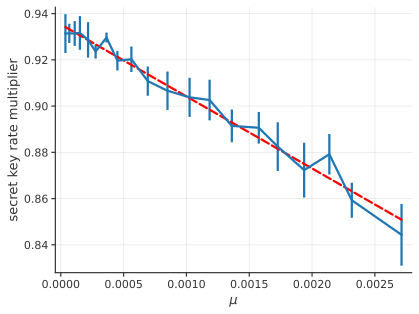

In [207]:


secret_key_multiplier = np.polyfit(mus, secret_key_mult(tomography_result.qber.avg), 1)
# secret_key_multiplier = np.polyfit(mus, secret_key_mult(qber_test), 1)


secret_key_line = Line(secret_key_multiplier[0], secret_key_multiplier[1])


plt.errorbar(
    mus,
    secret_key_mult(tomography_result.qber.avg),
    yerr=secret_key_mult(tomography_result.qber.avg - tomography_result.qber.std)
    - secret_key_mult(tomography_result.qber.avg + tomography_result.qber.std),
    label="QBER",
)
# plt.errorbar(
#     mus,
#     secret_key_mult(qber_test),
#     yerr=secret_key_mult(qber_test - qber_std_test)
#     - secret_key_mult(qber_test + qber_std_test),
#     label="QBER",
# )

plt.plot(mus, secret_key_line(mus), ls="--", label="linear fit", color='r')

# plt.title("secret key rate multiplier vs $\mu$")
plt.xlabel("$\mu$")
plt.ylabel("secret key rate multiplier")

In [101]:
import json
with open("mcr.json", "r") as file:
    mcr_data = json.load(file)

# mcr_data.keys()
mcr_count_rates = mcr_data["count_rates"]
mcr_eff_efficiencies = mcr_data["eff_efficiencies"]


secret key rate error due to qber [  3.29410733   2.83127963   5.96126873  11.15013364  16.87582368
   8.14773043   7.24568872  18.5067952   30.23265558  42.49009333
  66.28828907  81.02407891  97.02398056  89.34678445  98.60239404
 165.97557115 213.05795436 169.2371869  158.00670495 320.96270865]
secret key rate error due to rate [ -10.49301797   -9.37534962  -11.07533588   -7.61013655  -14.61388497
  -22.51487033  -46.08342659  -56.65528921  -51.02341934  -54.15623448
  -20.63313291  -27.60379627  -91.78828184  -48.34093922 -117.92512806
  -61.02485905 -116.77777978 -163.5400109  -220.33688706 -245.24230899]
dict_keys(['wavelengths', 'zero_subtracted', 'data_convolved', 'signal_full', 'idler_full', 'idler_8x', 'signal_8x', 'idler_16x', 'signal_16x'])
['..', 'figs', 'ext']
../figs/
pickleable


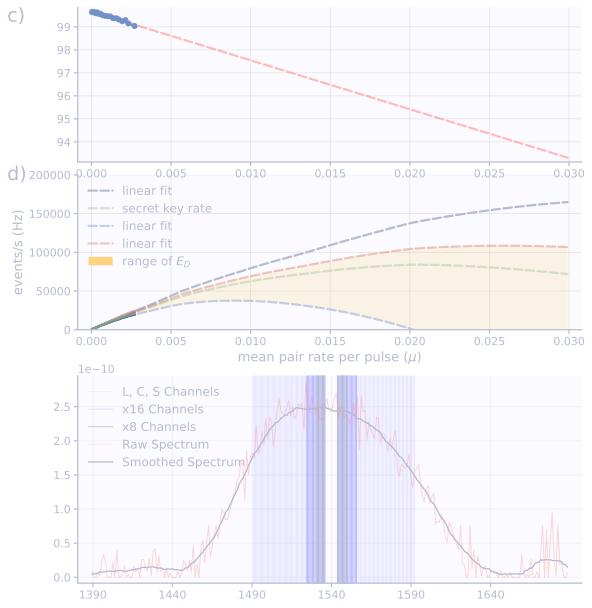

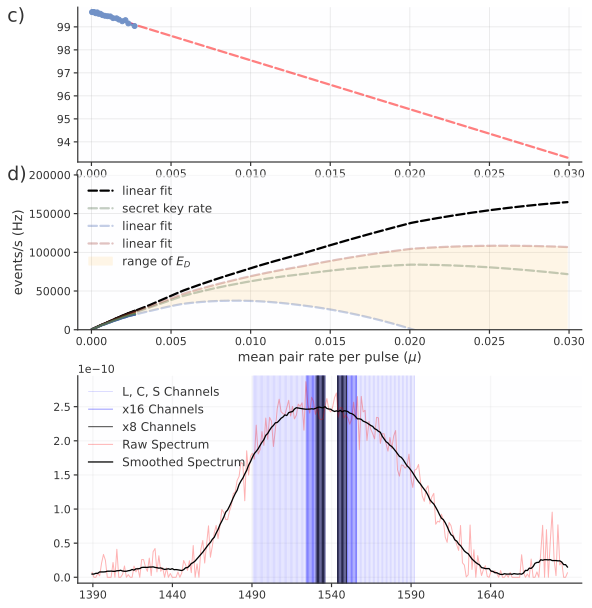

In [205]:
fig = plt.figure(figsize=(7, 8))
divider_width = 0.02

bottom, top = bisect(
    [0, 0, 1, 1],
    direction="horiz",
    offset=0.4,
    spacing=divider_width * 4,
    absolute_spacing=True,
)


b, t = bisect(
    top,
    direction="horiz",
    offset=0.5,
    spacing= divider_width * 2,
    absolute_spacing=False,
)




ex_fidelities = fig.add_axes(t)
ex_rates = fig.add_axes(b)
spectrum = fig.add_axes(bottom)


singles_A_coeffs = np.polyfit(mus, singles_A, 1)
singles_A_line = Line(singles_A_coeffs[0], singles_A_coeffs[1])



# mus_long = np.arange(1, 200) / 10000
# plt.plot(mus_long, singles_A_line.slope * mus_long + singles_A_line.intercept, color="red", linestyle="--", label="linear fit", alpha=0.5)





def plot_extrapolated_fidelities(ax, res: TomoOutput, fidelity_line: Line):
    mus_long = np.arange(1, 300) / 10000
    ax.plot(
        mus_long,
        fidelity_line.slope * mus_long + fidelity_line.intercept,
        color="red",
        linestyle="--",
        label="linear fit",
        alpha=0.5,
    )
    plot_fidelities(ax, mus, res, zoomed_out=True)


def plot_extrapolated_rates(
    ax, res: TomoOutput, rates_line: Line, log_neg_line: Line, coh_info_line: Line
):
    mus_long = np.arange(1, 300) / 10000


    ef_eff = np.interp(singles_A_line.slope * mus_long + singles_A_line.intercept, mcr_count_rates, mcr_eff_efficiencies)**2
    # print(ef_eff)

    diff_single_pixel_rates = (rates_line.slope * mus_long + rates_line.intercept)*ef_eff
    # raw rates extrapolation
    ax.plot(
        mus_long,
        diff_single_pixel_rates,
        color="black",
        linestyle="--",
        label="linear fit",
    )

    # secret key rate extrapolation
    secret_key_ln = secret_key_line(mus_long) * diff_single_pixel_rates
    ax.plot(
        mus_long,
        secret_key_ln,
        color=Colors["dark_green"],
        linestyle="--",
        label="secret key rate",
        alpha=0.3,
    )



    # coherent info extrapolation

    coh_info_ln = coh_info_line(mus_long) * diff_single_pixel_rates
    ax.plot(
        mus_long,
        coh_info_ln,
        color=Colors["dark_blue"],
        linestyle="--",
        label="linear fit",
        alpha=0.3,
    )

    # log negativity extrapolation
    log_neg_ln = log_neg_line(mus_long) * diff_single_pixel_rates
    ax.plot(
        mus_long,
        log_neg_ln,
        color=Colors["dark_red"],
        linestyle="--",
        label="linear fit",
        alpha=0.3,
    )

    ax.fill_between(
        mus_long,
        log_neg_ln,
        coh_info_ln,
        alpha=0.1,
        color="orange",
        label=r"range of $E_D$",
    )

    ax.set_ylim(0, 200000)
    ax.legend(frameon=False)

    plot_rates(ax, mus, res)


def plot_spectrum(ax):
    d = DataObj.from_file("spectrum_graph.json")
    for i, (signal, idler) in enumerate(zip(d.signal_full, d.idler_full)):
        if i == 0:
            ax.axvline(signal, color='b', alpha=.2, lw=0.7, label='L, C, S Channels')
        else:
            ax.axvline(signal, color='b', alpha=.2, lw=0.7)
        ax.axvline(idler, color='b', alpha=.2, lw=0.7)

    for i, (signal, idler) in enumerate(zip(d.signal_16x, d.idler_16x)):
        if i == 0:
            ax.axvline(signal, color='b', alpha=.5, lw=0.8, label='x16 Channels')
        else:
            ax.axvline(signal, color='b', alpha=.5, lw=0.8)
        ax.axvline(idler, color='b', alpha=.5, lw=0.8)


    for i, (signal, idler) in enumerate(zip(d.signal_8x, d.idler_8x)):
        if i == 0:
            ax.axvline(signal, color='k', alpha=1, lw=0.7, label='x8 Channels')
        else:
            ax.axvline(signal, color='k', alpha=1, lw=0.7)
        ax.axvline(idler, color='k', alpha=1, lw=0.7)


    ax.plot(d.wavelengths, d.zero_subtracted, color='r', alpha=.3, label='Raw Spectrum', lw=1)
    ax.plot(d.wavelengths, d.data_convolved, color='k', lw=1.3, label='Smoothed Spectrum')

    legend = ax.legend(frameon=False)
    _ = ax.set_xticks(1540 + 50*np.arange(-3,3))
    ax.grid(alpha=.1, lw=1.4)

plot_extrapolated_fidelities(ex_fidelities, tomography_result, fidelity_line)
plot_extrapolated_rates(
    ex_rates, tomography_result, rates_line, log_neg_line, coh_info_line
)

ex_fidelities.text(
    -0.14, 1, "c)", transform=ex_fidelities.transAxes, fontsize=19, va="top"
)
ex_rates.text(
    -0.14, 1.06, "d)", transform=ex_rates.transAxes, fontsize=19, va="top"
)


plot_spectrum(spectrum)

viz.save_light_dark_all(fig, "../figs/ext", override_alpha=True)


There are a few different 'limits' to count rate that may be important, depending on the application.

1. Limited by coherent information (advanced network)
2. Limited by log negativity (advanced network)
3. Limited by quantum bit error rate (can I easily calculate it?)
4. Limited by detector count rate?

You need to figure out the sequence of these.

Okay, I'm going to go to lab and I'm going to test the max count rate.
No, you're only going to do that after Sam gets back. For now, you're going
to continue reading Gregor's paper so that you stay in the office in case
Sam gets back.


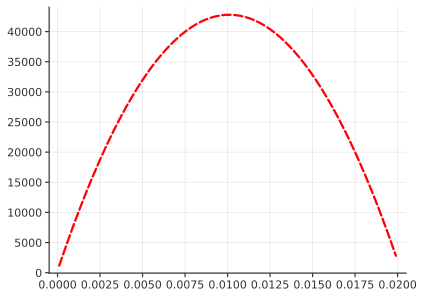

In [ ]:
def quadratic_coherent_info(mu):
    return (slope_ln * mu + intercept_ln) * (slope_rates * mu + intercept_rates)


mu_x = np.arange(1, 200) / 10000
plt.plot(
    mu_x,
    quadratic_coherent_info(mu_x),
    color="red",
    linestyle="--",
    label="quadratic fit",
)

Okay so the fit the the coherent infos rates line is quadratic, because it's the product of two things (count rate and coherent info) that both appear to vary linearly with mu. Therefore, 'coherent info rates' line has a maximum at about $\mu = 0.01$. We might just use this to define the maximum throughput per channel. At $\mu=0.01$, fidelity is expected to be (0.01)*-212.56 + 99.67% = 97.54%. Then what count rate would be be expecting? Well coincidence rate would be about 4 times higher, and coincidence rate scales linearly with \mu in this regime. So you can expect around ~(70 Kcoincs/s*4)\*4 ~ 1.12 Mcoincidences per second. Raw detector count rates would scale linearly as well


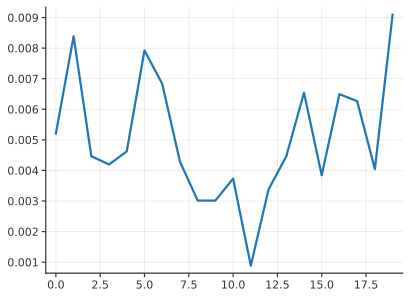

In [ ]:
plt.plot(coherent_infos_std)

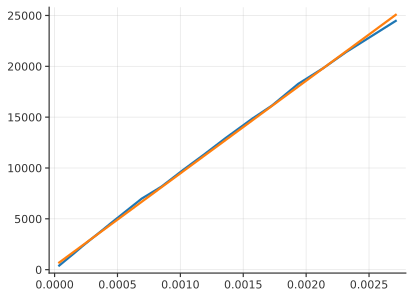

In [ ]:
plt.plot(mus, rates_avg)
coeffs_rates = np.polyfit(mus, rates_avg, 1)
slope_rates = coeffs_rates[0]
intercept_rates = coeffs_rates[1]
plt.plot(mus, slope_rates * mus + intercept_rates)

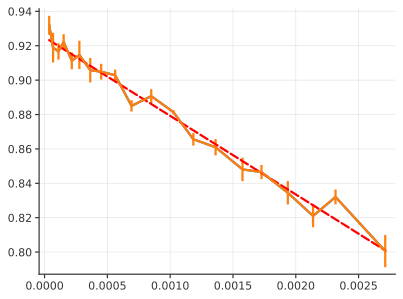

In [ ]:
plt.plot(mus, coherent_infos_avg)

plt.errorbar(mus, coherent_infos_avg, yerr=coherent_infos_std)
coeffs_ln = np.polyfit(mus, coherent_infos_avg, 1)
slope_ln = coeffs_ln[0]
intercept_ln = coeffs_ln[1]
plt.plot(
    mus, slope_ln * mus + intercept_ln, color="red", linestyle="--", label="linear fit"
)

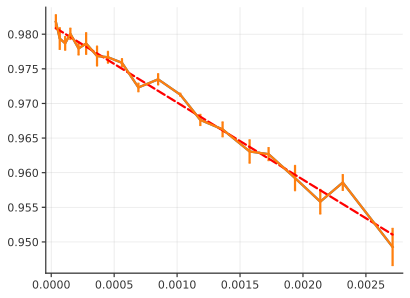

In [ ]:
plt.plot(mus, log_negativities_avg)

plt.errorbar(mus, log_negativities_avg, yerr=log_negativities_std)
coeffs_ln = np.polyfit(mus, log_negativities_avg, 1)
slope_ln = coeffs_ln[0]
intercept_ln = coeffs_ln[1]
plt.plot(
    mus, slope_ln * mus + intercept_ln, color="red", linestyle="--", label="linear fit"
)

In [ ]:
np.arange(mus[-1] * 5000) / 5000

array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
       0.0016, 0.0018, 0.002 , 0.0022, 0.0024, 0.0026])

In [ ]:
coherent_infos_avg

array([0.93191286, 0.91892666, 0.91669026, 0.92220325, 0.91120481,
       0.91468854, 0.90575006, 0.90492058, 0.90284674, 0.88503261,
       0.89068627, 0.8814542 , 0.86560704, 0.86096327, 0.84808455,
       0.84651116, 0.83447668, 0.82102633, 0.83205359, 0.80058857])

In [ ]:
print(tomo)

phase		|dd>		|dr>		|rd>		|rr>
ee: 		3493.2		3941.93		3941.93		4105.61		
el: 		37.65		54.2		54.2		54.33		
ed: 		3055.69		0.0		3280.23		0.0		
er: 		0.0		3280.23		0.0		3457.29		
le: 		20.15		27.1		27.1		29.5		
ll: 		2149.91		2412.39		2412.39		2476.74		
ld: 		2534.39		0.0		2726.08		0.0		
lr: 		0.0		2726.08		0.0		2819.52		
de: 		2846.21		3108.11		0.0		0.0		
dl: 		2734.32		2905.99		0.0		0.0		
dd: 		10774.99	0.0		0.0		0.0		
dr: 		0.0		5774.79		0.0		0.0		
re: 		0.0		0.0		3108.11		3284.43		
rl: 		0.0		0.0		2905.99		3023.75		
rd: 		0.0		0.0		5774.79		0.0		
rr: 		0.0		0.0		0.0		108.12		



In [ ]:
power_idx = 19
iter_idx = 0

sect = power_steps[power_idx].phase_90[iter_idx]
Sa = np.sum(sect.singles_hist_1) / sect.delta_time
Sb = np.sum(sect.singles_hist_2) / sect.delta_time
Cc = sect.total_coincidences / sect.delta_time

In [ ]:
total_singles = (Sa + Sb) * 2
total_coincidences = Cc * 4

In [ ]:
col1 = [
    2.5,
    2.505,
    2.51,
    2.515,
    2.52,
    2.525,
    2.53,
    2.535,
    2.54,
    2.545,
    2.55,
    2.555,
    2.56,
    2.565,
]
col2 = [
    4.8,
    3.943,
    3.864,
    3.088,
    2.299,
    2.065,
    2.099,
    1.989,
    1.821,
    2.077,
    2.31,
    2.478,
    3.031,
    3.244,
]

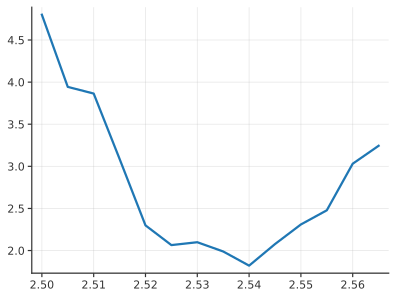

In [ ]:
plt.plot(col1, col2)

In [ ]:
np.average(
    [
        0.899,
        0.666,
        0.566,
        0.699,
        0.7,
        0.766,
        0.533,
        0.799,
        0.733,
        0.867,
        1.0,
        0.566,
        0.633,
        0.865,
        0.833,
        1.132,
        1.032,
        0.732,
        0.998,
        0.766,
        0.965,
        0.633,
    ]
)

0.7901363636363636